### This notebook provides the code for diversity audit of collections from CelebA dataset

In [89]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os, sys, glob, re
from scipy.spatial import distance

from tqdm.notebook import tqdm
from IPython.display import Markdown, display
from matplotlib.pyplot import figure
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
def getModel():
	#Load the VGG model
	return VGG16(weights='imagenet', include_top=True)	

def getFeatureExtractor():
	model = getModel()
	feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
	return feat_extractor

def loadImage(path, target_size):
	img = image.load_img(path, target_size=target_size)
	x = image.img_to_array(img)
	x = np.expand_dims(x, axis=0)
	x = preprocess_input(x)
	return img, x

def getFeature(inp):
    image_path = inp[0]
    feat_extractor = inp[1]
    target_size = inp[2]
    try:
        img, x = loadImage(image_path, target_size);
        feat = feat_extractor.predict(x)[0]

        return feat
    except Exception as e:
        print (inp, e)
        return []

In [6]:
# Get CelebA dataset from http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
DATASET_PATH = ''

test_set = np.load('./celeba_testset.out')
imagePaths = [DATASET_PATH + img for img in test_set]

feat_extractor = getFeatureExtractor()
model = getModel()
target_size=model.input_shape[1:3]

In [9]:
# Extract features for images

imageToFeatures = {}
for path in tqdm(imagePaths):
    feat = getFeature([DATASET_PATH+path, feat_extractor, target_size])
    if len(feat) == 0:
        continue
    imageToFeatures[path] = list(feat)

In [16]:
from sklearn import decomposition
svd = decomposition.TruncatedSVD(n_components=300, algorithm='arpack')

features = list(imageFeatures.values())
svd.fit(features)
pca_features = svd.transform(features)
imagePaths = list(imageFeatures.keys())

imageFeatures = dict(zip(imagePaths, pca_features))


In [54]:
attributes = np.load('./output/imageAttributes.out', allow_pickle=True)[()]

trueGenderLabels = {}
mImages, fImages = [], []

for path in imagePaths:
    p = path.split('/')[-1]
    if "Male" in attributes[p]:
        trueGenderLabels[path] = "m"
        mImages.append(path)
    else:
        trueGenderLabels[path] = "f"
        fImages.append(path)

len(mImages), len(fImages)

(7715, 12247)

In [216]:
def getBounds(control):
    def condition(g,s):
        return g=="f"

    validation_m, validation_f = [], []
    for i in range(len(control)):
        g, s = trueGenderLabels[control[i]], trueGenderLabels[control[i]]
        if condition(g, s):
            validation_f = validation_f + [control[i]]
        else:
            validation_m = validation_m + [control[i]]

    simMatrix = np.array([np.array([sim(img1, img2) for img1 in validation_m if img1 != img2]) for img2 in control])
    simSum = [np.mean(simMatrix[i]) for i in range(len(simMatrix))]
    fs = np.mean([simSum[i] for i in range(len(simSum)) if condition(trueGenderLabels[control[i]], trueGenderLabels[control[i]])])
    ms = np.mean([simSum[i] for i in range(len(simSum)) if not condition(trueGenderLabels[control[i]], trueGenderLabels[control[i]])])
    lowerFS, upperMS = fs, ms
    lowerR = fs/(fs+ms)
    upperD1 = abs(fs-ms)

    simMatrix = np.array([np.array([sim(img1, img2) for img1 in validation_f if img1 != img2]) for img2 in control])
    simSum = [np.mean(simMatrix[i]) for i in range(len(simMatrix))]
    fs = np.mean([simSum[i] for i in range(len(simSum)) if condition(trueGenderLabels[control[i]], trueGenderLabels[control[i]])])
    ms = np.mean([simSum[i] for i in range(len(simSum)) if not condition(trueGenderLabels[control[i]], trueGenderLabels[control[i]])])
    upperFS, lowerMS = fs, ms
    upperR = fs/(fs+ms)
    upperD2 = abs(fs-ms)
    return lowerFS, lowerMS, upperFS, upperMS, validation_m, validation_f
    
    
# Random Control sets
def getRandomControlSet(images, k=20):
    def condition(g,s):
        return g=="f"
    
    k2 = int(k/2)
    mImages2 = [img for img in images if trueGenderLabels[img] == "m"]
    fImages2 = [img for img in images if trueGenderLabels[img] == "f"]
    
    control = mImages2[:k2] + fImages2[:k2]    

    lowerFS, lowerMS, upperFS, upperMS, validation_m, validation_f = getBounds(control)
    return control, lowerFS, lowerMS, upperFS, upperMS, validation_m, validation_f


# Adaptive control sets
def getGoodControlSet(images, k=20, alpha=1):
    mImages2 = [img for img in images if trueGenderLabels[img] == "m"]
    fImages2 = [img for img in images if trueGenderLabels[img] == "f"]
    
    k2 = int(k/2)

    control_0 = []
    gamma = []
    for img1 in mImages2:
        g_m = [sim(img1, img2) for img2 in mImages2 if img1 != img2]
        g_f = [sim(img1, img2) for img2 in fImages2 if img1 != img2]
        gamma.append(np.mean(g_m) - np.mean(g_f))
        
    gamma = np.array(gamma)
    red_score = np.array([0 for _ in mImages2])
    while len(control_0) < k2:
        choose = np.argmax(gamma - alpha*red_score)
        
        red_score_2 = []
        for i, img in enumerate(mImages2):
            red_score_2.append(max(red_score[i], sim(mImages2[choose], img)))
            
#         print (red_score)
        red_score = np.array(list(red_score_2))
        gamma[choose] = -100000
        control_0.append(mImages2[choose])
    
    control_1 = []
    gamma = []
    for img1 in fImages2:
        g_m = [sim(img1, img2) for img2 in mImages2 if img1 != img2]
        g_f = [sim(img1, img2) for img2 in fImages2 if img1 != img2]
        gamma.append(np.mean(g_f) - np.mean(g_m))
        
    gamma = np.array(gamma)
    red_score = np.array([0 for _ in fImages2])
    while len(control_1) < k2:
        choose = np.argmax(gamma - alpha*red_score)
        
        red_score_2 = []
        for i, img in enumerate(fImages2):
            red_score_2.append(max(red_score[i], sim(fImages2[choose], img)))
            
#         print (red_score)
        red_score = np.array(list(red_score_2))
        gamma[choose] = -100000
        control_1.append(fImages2[choose])

    control = control_0 + control_1

    lowerFS, lowerMS, upperFS, upperMS, validation_m, validation_f = getBounds(control)
    return control, lowerFS, lowerMS, upperFS, upperMS, validation_m, validation_f


control, lowerFS, lowerMS, upperFS, upperMS, validation_m, validation_f = getRandomControlSet(validation)
print (lowerFS, lowerMS, upperFS, upperMS)

control, lowerFS, lowerMS, upperFS, upperMS, validation_m, validation_f = getGoodControlSet(validation, alpha=0.3)
print (lowerFS, lowerMS, upperFS, upperMS)



0.4067784863710403 0.4067784863710403 0.5044320835007561 0.49374621046913986
0.20974554449319838 0.20974554449319838 0.7326386160320706 0.566598082251019


In [92]:
queries = np.load('./output/celeba_features.out', allow_pickle=True)[()]
queries

array(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Bags_Under_Eyes', 'Bald',
       'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup',
       'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache',
       'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pointy_Nose',
       'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling',
       'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat',
       'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='<U19')

In [140]:
trueSimFracsAll, trueDIsAll, datasets = {}, {}, {}
for o in queries:
    dataset = [p for p in imagePaths if o in attributes[p.split('/')[-1]]]
    fs = np.mean([1 if trueGenderLabels[p] == "f" else 0 for p in dataset])
    ms = np.mean([1 if trueGenderLabels[p] == "m" else 0 for p in dataset])
    trueSimFracsAll[o] = fs/(fs+ms)
    trueDIsAll[o] = (fs-ms)
    datasets[o] = list(dataset)
    

In [269]:
## DivScore

def calibrate(ys, lower, upper):
    return (ys-lower) / (upper - lower)

def getDIs(control, datasets):
    simFracs, DIs, SRs = {}, {}, {}
    for o in (queries):
        if trueSimFracsAll[o] < 0.1 or np.isnan(trueSimFracsAll[o]):
            continue

        dataset = datasets[o]
        dataset = [p for p in dataset if p not in control]
        if len(dataset) < 50:
            continue

        simMatrix = np.array([[sim(img1, img2) for img1 in dataset] for img2 in control])
        simSum = np.mean(simMatrix, axis=1)
        fs = np.mean([simSum[i] for i in range(len(simSum)) if condition(trueGenderLabels[control[i]], trueGenderLabels[control[i]])])
        ms = np.mean([simSum[i] for i in range(len(simSum)) if not condition(trueGenderLabels[control[i]], trueGenderLabels[control[i]])])

        fs = calibrate(fs, lowerFS, upperFS)
        ms = calibrate(ms, lowerMS, upperMS)
        rr = fs/(fs+ms)
        simFracs[o] = rr

        DIs[o] = (fs-ms)
    return DIs

reps = 10
p_size = 500

def condition(g,s):
    return g=="f"

# rDIsAll, gDIsAll = [], []
for _ in tqdm(range(reps)):
    
    random.shuffle(imagePaths)
    validation = imagePaths[:p_size]

    datasets = {}
    for o in queries:
        dataset = [p for p in imagePaths[p_size:] if o in attributes[p.split('/')[-1]]]
        fs = np.mean([1 if trueGenderLabels[p] == "f" else 0 for p in dataset])
        ms = np.mean([1 if trueGenderLabels[p] == "m" else 0 for p in dataset])
        datasets[o] = list(dataset)

    control, lowerFS, lowerMS, upperFS, upperMS, validation_m, validation_f = getRandomControlSet(validation, k=50)
    DIs = getDIs(control, datasets)
    rDIsAll.append(dict(DIs))

    control, lowerFS, lowerMS, upperFS, upperMS, validation_m, validation_f = getGoodControlSet(validation, k=50, alpha=1)
    DIs = getDIs(control, datasets)
    gDIsAll.append(dict(DIs))
    

In [271]:
gmeanDIs, gstdDIs = {}, {}
for o in tqdm(queries):
    gmeanDIs[o] = np.mean([gDIsAll[i][o]  if o in gDIsAll[i].keys() else 0 for i in range(len(gDIsAll))])
    gstdDIs[o] = np.std([gDIsAll[i][o] if o in gDIsAll[i].keys() else 0 for i in range(len(gDIsAll))])        

In [272]:
meanSimFracs, stdSimFracs, rmeanDIs, rstdDIs = {}, {}, {}, {}
for o in tqdm(queries):
    rmeanDIs[o] = np.mean([rDIsAll[i][o]  if o in rDIsAll[i].keys() else 0 for i in range(len(rDIsAll))])
    rstdDIs[o] = np.std([rDIsAll[i][o] if o in rDIsAll[i].keys() else 0 for i in range(len(rDIsAll))])        

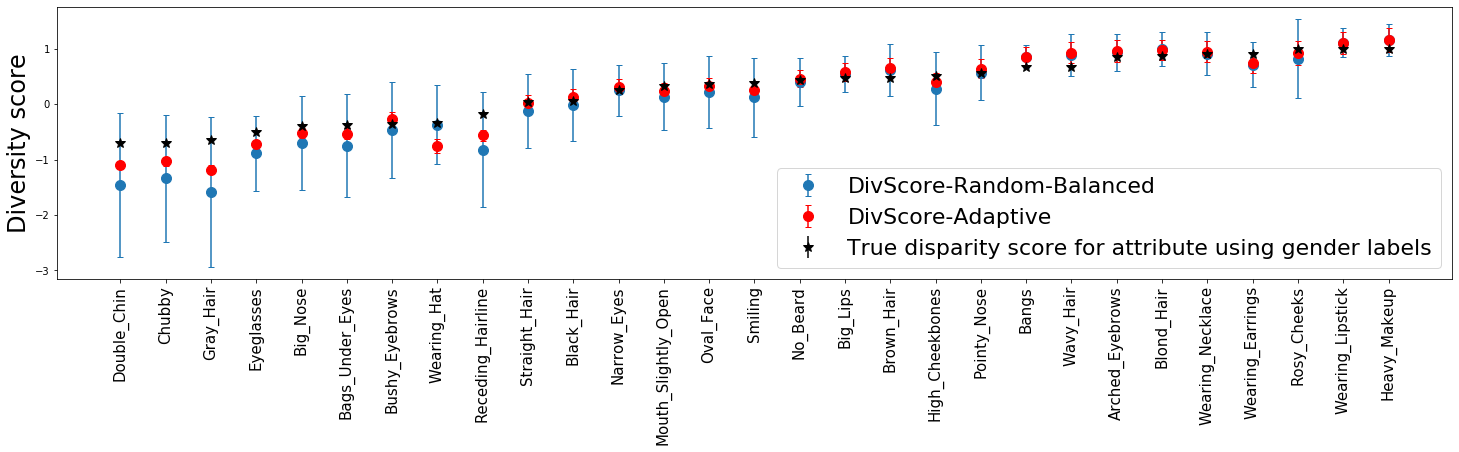

In [298]:
plt.figure(figsize=(25, 5))
xs, ys, yerr, ys2, yerr2, qs, diff = [], [], [], [], [], [], []
for o in queries:
    if o not in meanDIs.keys():
        continue
    qs.append(o)
    xs.append(trueDIsAll[o])    
    ys.append(rmeanDIs[o])
    yerr.append(rstdDIs[o])
    ys2.append(gmeanDIs[o])
    yerr2.append(gstdDIs[o])
    diff.append(abs(trueDIsAll[o]-meanDIs[o]))
xs, diff, ys, yerr, ys2, yerr2, qs = zip(*sorted(zip(xs, diff, ys, yerr, ys2, yerr2, qs)))    

plt.errorbar(list(range(len(xs))), ys, yerr, fmt="o", marker="o", color="#1f77b4", markersize=10, label="DivScore-Random-Balanced", capsize=3, capthick=1)
plt.errorbar(list(range(len(xs))), ys2, yerr2, fmt="o", marker="o", color="red", markersize=10, label="DivScore-Adaptive", capsize=3, capthick=1)
plt.errorbar(list(range(len(xs))), xs, [0]*len(xs), fmt="o", marker="*", color="black", markersize=10, label="True disparity score for attribute using gender labels")
# plt.plot(xs, np.poly1d(np.polyfit(xs,ys, deg=1))(xs))
plt.ylabel("Diversity score", fontsize=24)
plt.xticks(list(range(len(xs))), qs, rotation='vertical', fontsize=15)
plt.legend(fontsize=22)
# plt.xlabel("Gender fraction ground truth for attribute", fontsize=)